<a href="https://www.kaggle.com/code/hanpat99/text-analytics-dtm-tf-idf-vect-countvectorizer?scriptVersionId=135958597" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

- **This is a take home assignment on NLP and Text Analytics**

 

# Topics covered:
- Text preprocessing
- n-grams, Visualization
- DTM conversion of text data
- WordCloud Visualizations 

Problem statement:



For the given data from the amazon reviews, reviewText column, perform the below activities:

 

1. **Clean** the data

2. **Plot** a bigram bar graph on the top words 15 words

3. **Find** customer concern areas - the top 15 bigrams which includes the below negative words indicating the customer concern areas

> 'poor', 'waste', 'bad', 'defective', 'disgusting', 'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow'

4. **Plot** a bar graph for the top 15 customer concern areas

5. Prepare **word cloud** for the above mentioned conditions

<a id="0"></a>

<a id="0"></a>
# Workflow
- [0. Imports and data loading](#0.1)
- [1. Understanding the data](#1) 
- [2. Preprocessing](#2)
    >- [2.1. Missing Values, Duplicates Handling](#2.1)
    >- [2.2. Convert doucuments to lower case](#2.2)
    >- [2.3. Remove Punctuations](#2.3)
    >- [2.4. Identify Domain words from wordcloud](#2.4)
    >- [2.5. Import english stopwords list, remove the wordlist below, add domain words](#2.5)
>         -> 'poor', 'waste', 'bad', 'defective', 'disgusting', 'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow'
    >- [2.6. Build custom cleanup function and finish preprocessing](#2.6)
- [3. Bigram visualizations: Identifying customer pain points with select keywords](#3)
- [4. Wordcloud: Visualizing top 15 customer bigrams from the list provided](#4)
- [5. Analysis and Recommendations](#5)

<a id="0.1"></a>

# [0. Imports and data loading](#0)

In [1]:
## Import block 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=15,8
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.float_format', lambda x: '%.2f' % x)

#nltk
import nltk
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Load dataset
path = '/kaggle/input/amazon-reviews-dataset/Amazon_reviews_csv.xlsm'
df = pd.read_excel(path)


<a id="1"></a>
# [1. Understanding the data](#0)

In [3]:
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,528881469,"[0, 0]",5,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200
1,1,528881469,"[12, 15]",1,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200
2,2,528881469,"[43, 45]",3,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400
3,3,528881469,"[9, 10]",2,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800
4,4,528881469,"[0, 0]",1,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400


**ASIN stands for Amazon Standard Identification Number.**
Each product listed on Amazon has a unique ASIN, which helps identify and track the product. ASINs are used by Amazon to manage its product catalog and facilitate product identification, search, and categorization on the platform. ASINs are specific to Amazon and are not used as universal product identifiers.

**Helpful feature** typically us how much user have voted on the helpfulness of a review. A helpfulness tuple (4,6) indicates that 6 users have voted on a review, and 4 have found it to be helpful. 

**Overall** features describes the overall rating provided by the a reviewer and indicates the customer's overall satisfaction or opinion about the product on a numerical scale. The "overall" feature typically ranges from 1 to 5, with 1 being the lowest rating and 5 being the highest rating.

<a id ='2'></a>
# [2. Preprocessing](#0)

**reviewTime feature** gives us the datetime information about the review.

In [4]:
## Lets convert the text value into manipulatable datetime format
df['reviewTime'] = pd.to_datetime(df['reviewTime'], format='%m %d, %Y')

In [5]:
## First Lets conver Unix timestamp to datetime
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

<a id ='2.1'></a>
## [2.1 Missing Values, Duplicates Handling](#0)

In [6]:
df.isna().sum()

Unnamed: 0        0
asin              0
helpful           0
overall           0
reviewText        2
reviewTime        0
reviewerID        0
reviewerName      5
summary           0
unixReviewTime    0
dtype: int64

**I will drop where reviewText is NA, since they do not provide any information for my analysis.**

In [7]:
df = df.dropna(subset=['reviewText'])
df['reviewerName'] = df['reviewerName'].fillna('Missing')
df.shape

(997, 10)

In [8]:
review_text = df['reviewText']
review_text

0      We got this GPS for my husband who is an (OTR)...
1      I'm a professional OTR truck driver, and I bou...
2      Well, what can I say.  I've had this unit in m...
3      Not going to write a long review, even thought...
4      I've had mine for a year and here's what we go...
                             ...                        
994    A cable runs lifetime. Excellent product that ...
995    Quality of connection and video seems good wit...
996    What is there to say?  I needed a cable to run...
997    I can find nothing wrong with this cable.  It ...
998    Works perfectly at 1080p HD and in all other C...
Name: reviewText, Length: 997, dtype: object

<a id ='2.2'></a>
## [2.2 Convert documents to lower case](#0)

In [9]:
## Convert to lower case
df['tokenized'] = df['reviewText'].str.lower()

<a id="2.3"></a>
## [2.3 Remove Punctuations](#0)

In [10]:
import re

def punct_remove(x):
    reviews_combined_clean = re.sub("[^\w\s]+"," ",x)
    return reviews_combined_clean

In [11]:
df['tokenized'] = df['tokenized'].apply(lambda x: punct_remove(x))
df['tokenized'][:5]

0    we got this gps for my husband who is an  otr ...
1    i m a professional otr truck driver  and i bou...
2    well  what can i say   i ve had this unit in m...
3    not going to write a long review  even thought...
4    i ve had mine for a year and here s what we go...
Name: tokenized, dtype: object

<a id="2.4"></a>
## [2.4 Identify domain words from wordcloud](#0)

In [12]:
## Get the full corpus of tokens
full_join = " ".join(df['reviewText'].values)
full_join_list = full_join.split(' ')

## Lets check the count of the special tokens
bad10 = ['poor', 'waste', 'bad', 'defective', 'disgusting', \
         'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow']
bad_10_dict= {}
for word in bad10:
    bad_10_dict[word] = len(re.findall(pattern = word, string = full_join ))
bad_10_dict

{'poor': 23,
 'waste': 11,
 'bad': 70,
 'defective': 13,
 'disgusting': 0,
 'untrusty': 0,
 'worst': 3,
 'horrible': 7,
 'unexpectedly': 0,
 'slow': 50}

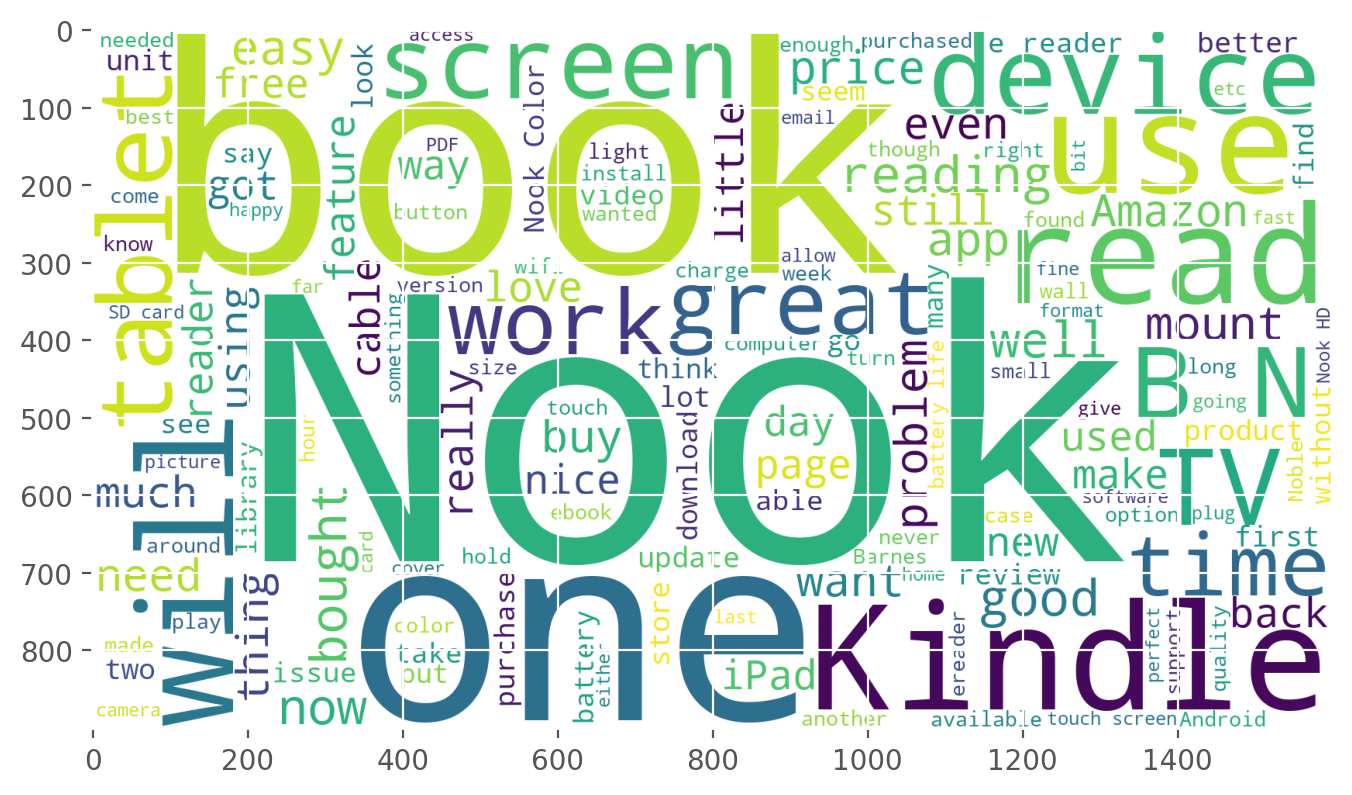

In [13]:
## Lets build a wordcloud now to identify domain words

plt.style.use('ggplot')
from wordcloud import WordCloud

word_cloud = WordCloud(width=1600,height=900,
                       background_color='white',
                       max_words=150).generate(full_join)

%config InlineBackend.figure_format="retina"
plt.figure(figsize=[8,8])
plt.imshow(word_cloud)
plt.savefig('Reviews word cloud.png')
plt.show()

We can observe that **nook, book, one, kindle, device, tablet,** are the domain words. Upon further research, it is clear that **the reviews are for the product "Barnes & Noble Nook".** Mentions of competitor products like Kindle, etc may refer to a large number of users comparing the Nook to the Kindle, in their reviews.

**Let's add these above domain words to the final StopWords.**

**Looks like our terms of interest, the Bad10 aren't showing up in the word cloud. We have to be careful while setting up the DTM so as to not truncate our terms. Let's add these to our retain words set.**

Lets identify any other negative words from this corpus and remove them.

<a id="2.5"></a>
**[2.5. Import english stopwords list, remove the wordlist below, add domain words](#0)**

In [14]:
## Get English StopWords and remove from documents
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_nltk = stopwords.words("english")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_nltk

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
retain_set = {'against','ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
 "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn',
 "wouldn't",'don', "don't", 'no', 'nor', 'not', 'only','from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
 'again', 'further', 'then', 'once', 'here', 'poor', 'waste', 'bad', 'defective', 'disgusting', 
         'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow' }

drop_set = {'no problem', 'problem', 'nook', 'book', 'one', 'device', 
'barnes', 'noble', 'barnes and noble', 'barnes noble', 'barnes & noble'}

In [17]:
stop_words_updated = list(set(stop_nltk).union(drop_set) - retain_set)

<a id="2.6"></a>
## [2.6. Build custom function and finish preprocessing](#0)

Now that our **stop words list is finalized**, and basic preprocessing is done, let's also **lemmatize our documents** and do the final preprocessing tasks.

In [18]:
## Lemmatize all documents in the dataset
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemma = WordNetLemmatizer()

## Uncomment and run only if encountering an error during document_lemmatizer() function calls
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [19]:

## Custom function to clean text, lemmatize, and drop stop_words
def document_lemmatizer(document):
    ## Trim white spaces
    sent = document.strip()
    
    ## Replace non-alphanumeric and non-space charecters with space
    result1 = re.sub("[^\w\s]"," ",sent)
    
    ## Replace any multiple spaces with a single space
    result = re.sub("\s+", " ", result1)
    tokens = word_tokenize(result.lower())
    lemm_token = [lemma.lemmatize(term) 
                  for term in tokens 
                  if term not in stop_words_updated 
                  and len(term)>2]
    
    result = " ".join(lemm_token)
    return result

In [20]:
df['tokenized'] = df['tokenized'].apply(lambda x: document_lemmatizer(x))
df['tokenized']

0      got gps husband otr over road trucker impresse...
1      professional otr truck driver bought tnd 700 t...
2      well say unit truck four day prior garmin 755t...
3      not going write long review even thought unit ...
4      mine year here got try route down non truck ro...
                             ...                        
994    cable run lifetime excellent product longer we...
995    quality connection video seems good fujifilm f...
996    say needed cable run from camera needed work e...
997    find nothing wrong cable work perfectly great ...
998    work perfectly 1080p canon eos mode cost le pr...
Name: tokenized, Length: 997, dtype: object

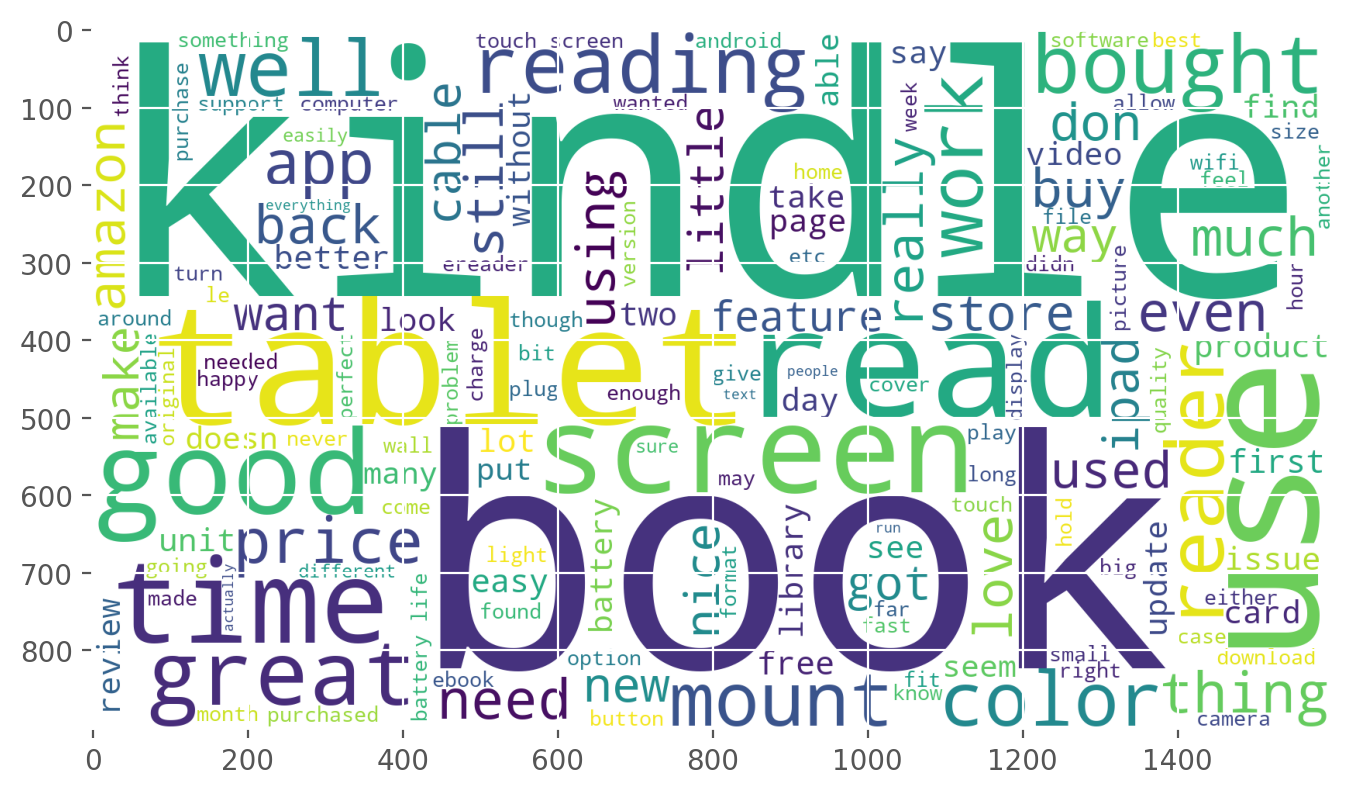

In [21]:
## Lets build a wordcloud now to identify

clean_tokens_join = " ".join(df['tokenized'].values)
from wordcloud import WordCloud

word_cloud = WordCloud(width=1600,height=900,
                       background_color='white',
                       max_words=150).generate(clean_tokens_join)
%config InlineBackend.figure_format="retina"
plt.figure(figsize=[8,8])
plt.imshow(word_cloud)
plt.savefig('Cleaned Reviews word cloud.png')
plt.show()

In [22]:
## Create bigrams for documents
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## create a bigram count vectorizer object
bigram_count_vec = CountVectorizer(ngram_range=(2,2))
bigram_tfidf = TfidfVectorizer(ngram_range=(2,2)) 

## Build bigram sparse matrices usind CountVectorizer and Tf-IDF Vectorizer
X_bigram_tfidf = bigram_tfidf.fit_transform(df['tokenized'])
X_bigram_count_vec=  bigram_count_vec.fit_transform(df['tokenized'])

## Building Document-Term-Matrix with countvectorizer and TF-IDF
DTM_bigram_tfidf  = pd.DataFrame(X_bigram_tfidf.toarray(), columns = bigram_tfidf.get_feature_names_out())
DTM_bigram_count_vec = pd.DataFrame(X_bigram_count_vec.toarray(), columns = bigram_count_vec.get_feature_names_out())

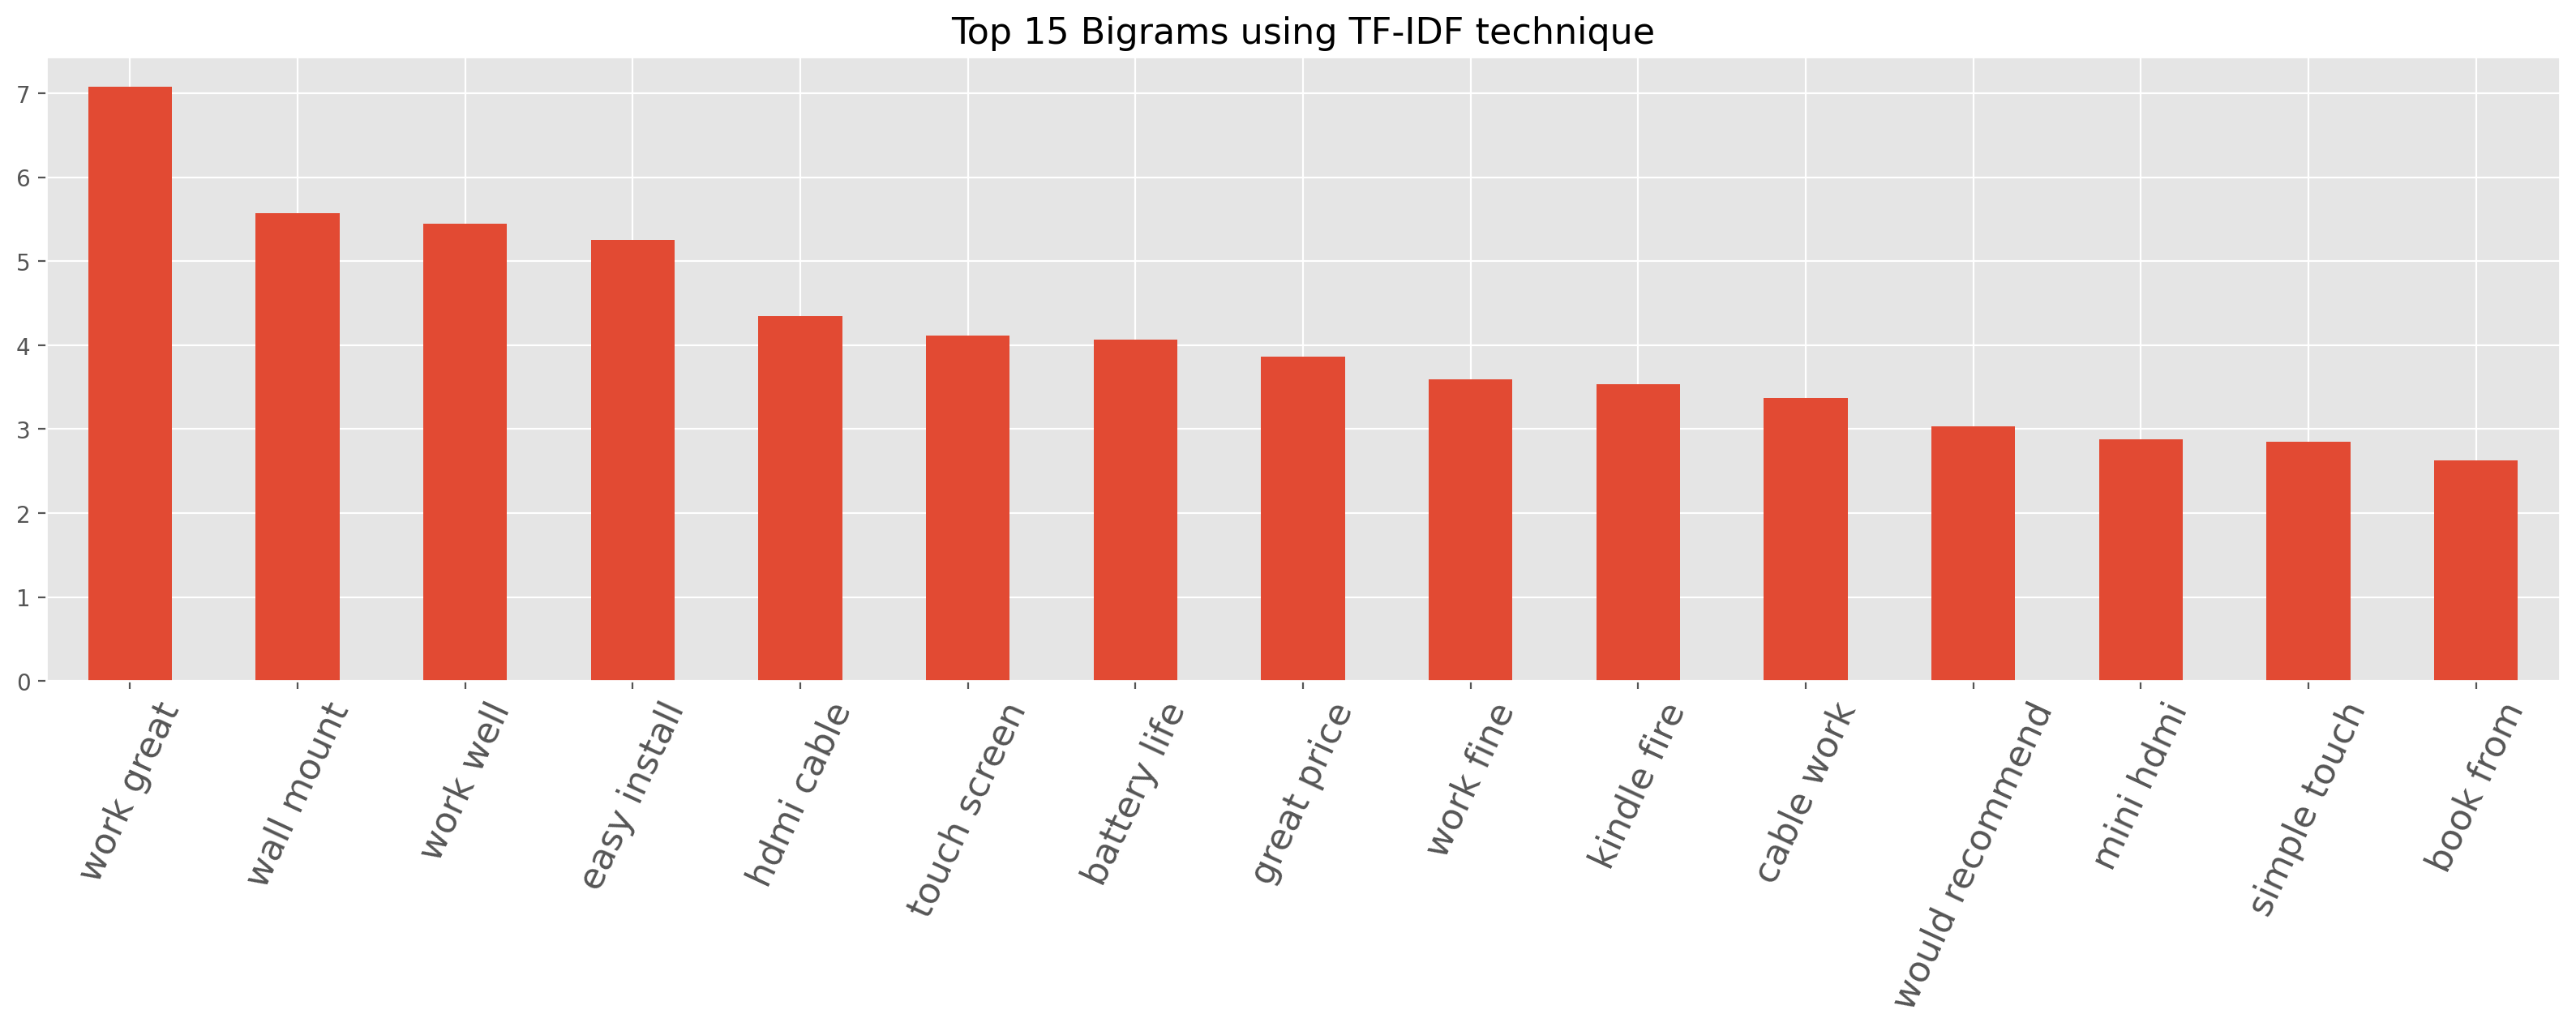

In [23]:
## Top 15 bigrams using tf-idf vectorizer
plt.style.use('ggplot')
%config InlineBackend.figure_format="retina"

DTM_bigram_tfidf.sum().sort_values(ascending=False).head(15).plot.bar(figsize=(20,5))

plt.xticks(rotation =65, fontsize=16)
plt.title('Top 15 Bigrams using TF-IDF technique', fontsize = 16)
plt.savefig('Top 15 Bigrams using TF-IDF technique.png')
plt.show();

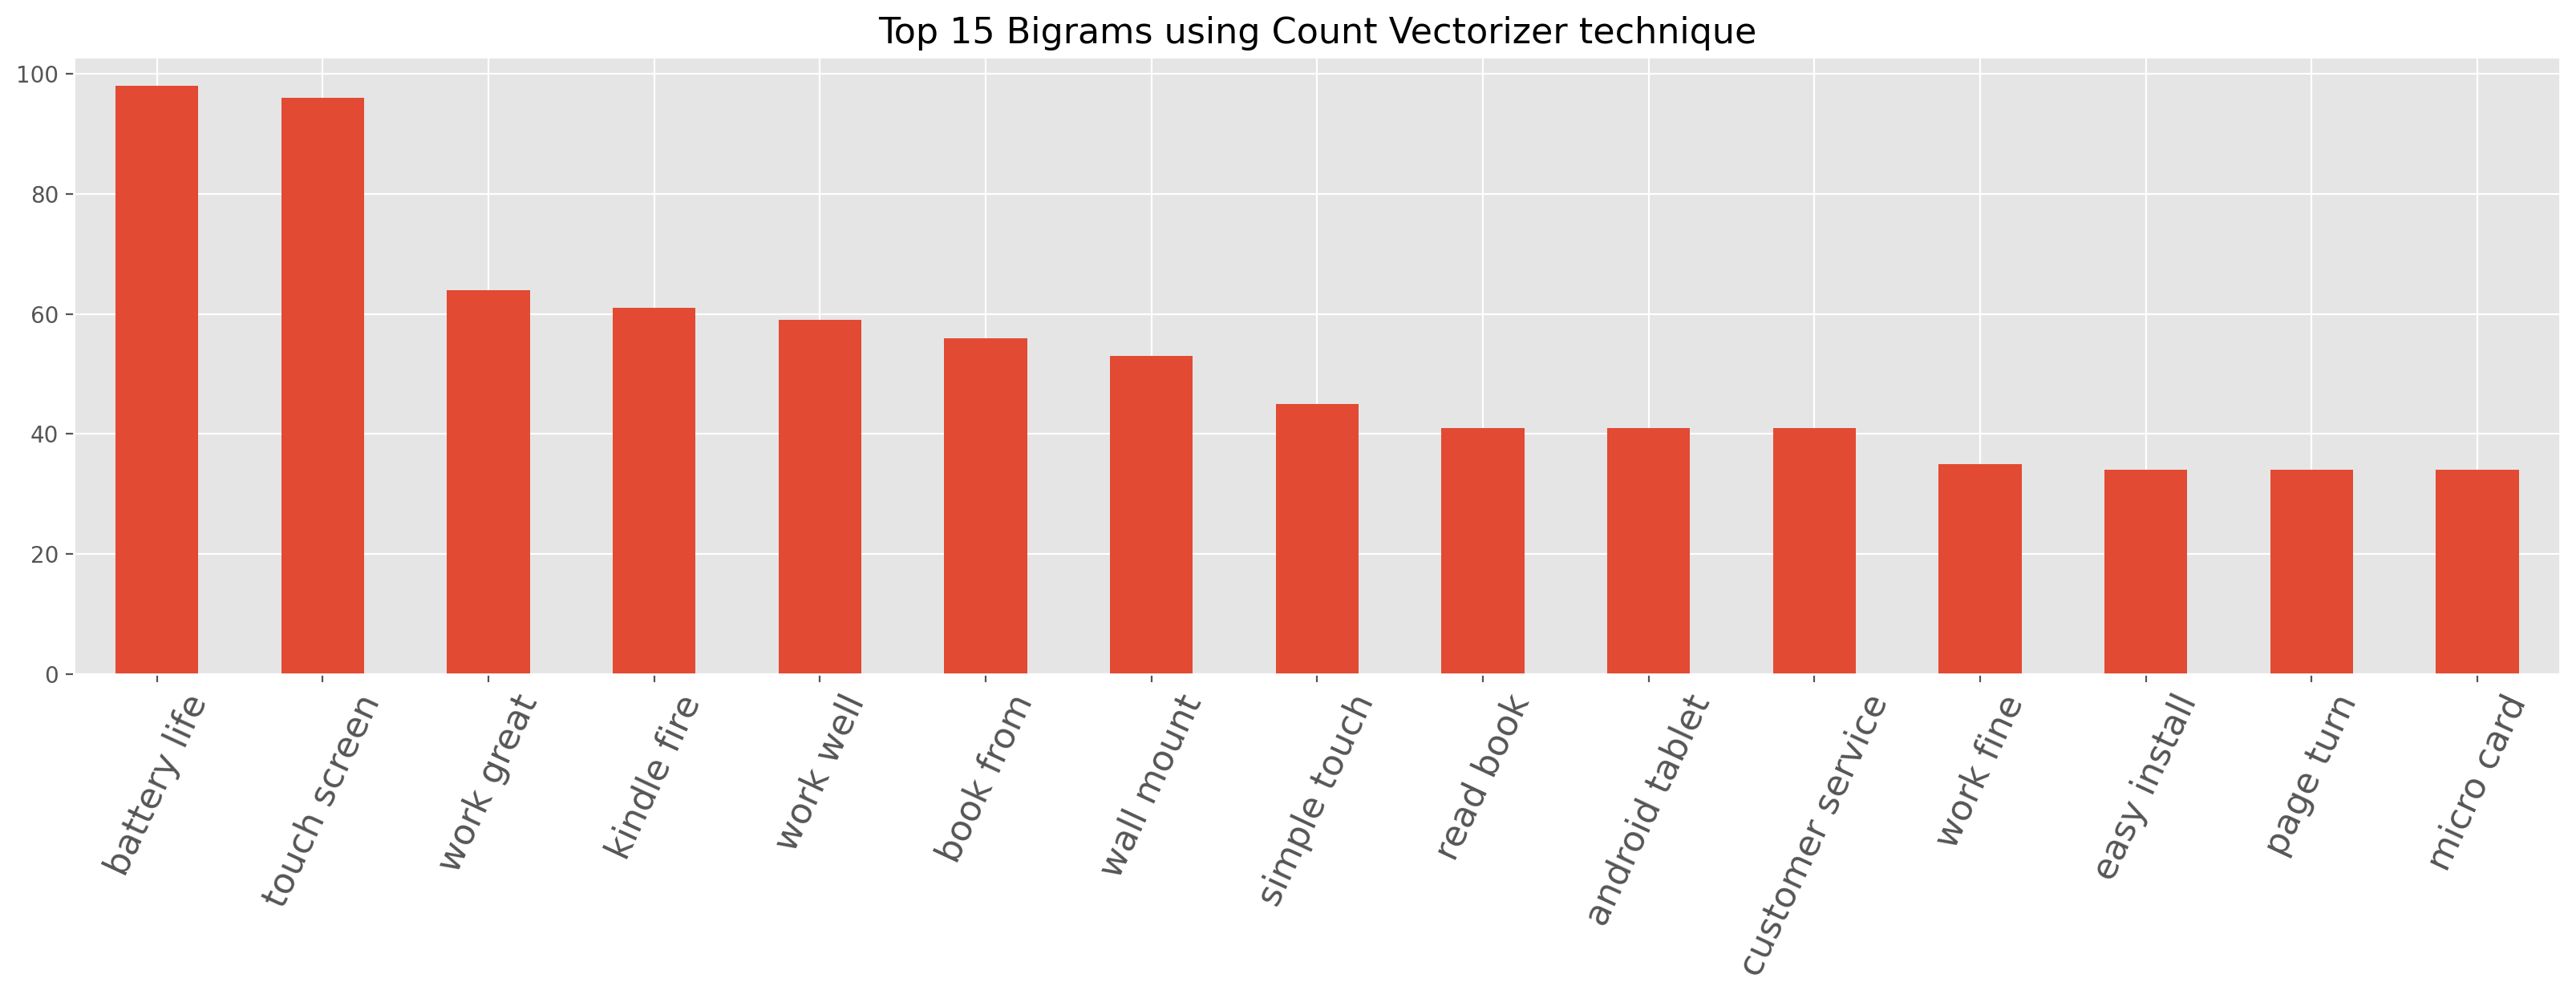

In [24]:
## Top 15 bigrams using count vectorizer

plt.style.use('ggplot')
%config InlineBackend.figure_format="retina"

DTM_bigram_count_vec.sum().sort_values(ascending=False).head(15).plot.bar(figsize=(20,5))

plt.xticks(rotation =65, fontsize=16)
plt.title('Top 15 Bigrams using Count Vectorizer technique', fontsize = 16)
plt.savefig('Top 15 Bigrams using Count Vectorizer technique.png')
plt.show();

**Tasks 1 & 2 - We have completed cleaning and visualizing top 15 bigrams by frequency.**

Lets now pay attention to the **Bad 10** - bigrams containing the terms in the below list:
> ['poor', 'waste', 'bad', 'defective', 'disgusting', 'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow']

In [25]:
DTM_bigram_tfidf.sum().sort_values(ascending=False)

work great           7.08
wall mount           5.57
work well            5.44
easy install         5.26
hdmi cable           4.34
                     ... 
android first        0.03
quickly video        0.03
much need            0.03
summary followed     0.03
get recommendation   0.03
Length: 54896, dtype: float64

In [26]:
DTM_bigram_count_vec.sum().sort_values(ascending=False)

battery life            98
touch screen            96
work great              64
kindle fire             61
work well               59
                        ..
give within              1
given choice             1
given crappy             1
given excruciatingly     1
zune place               1
Length: 54896, dtype: int64

In [27]:
tfidf_bigrams_list = list(DTM_bigram_tfidf.columns)
print('Total bigrams using Tf-IDf Vectorizer:', len(tfidf_bigrams_list))

count_vec_bigrams_list = list(DTM_bigram_count_vec.columns)
print('Total bigrams using Count Vectorizer:', len(count_vec_bigrams_list))

Total bigrams using Tf-IDf Vectorizer: 54896
Total bigrams using Count Vectorizer: 54896


<a id="3"></a>
# [3. Bigram visualizations: Identifying customer pain points with select keywords](#0)

In [28]:
## Specify the words to search for
bad_10_list = ['poor', 'waste', 'bad', 'defective', 'disgusting', \
                'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow']

## List to store the features containing the target words
tfidf_target_bad10_bigrams = []
## Iterate through each feature name
for feature in DTM_bigram_tfidf.columns:
    if any(word in feature for word in bad_10_list):
        tfidf_target_bad10_bigrams.append(feature)

count_vec_bad10_bigrams = []        
for feature in DTM_bigram_count_vec.columns:
    if any(word in feature for word in bad_10_list):
        count_vec_bad10_bigrams.append(feature)


## **Customer pain points with Tf-IDf of reviews**

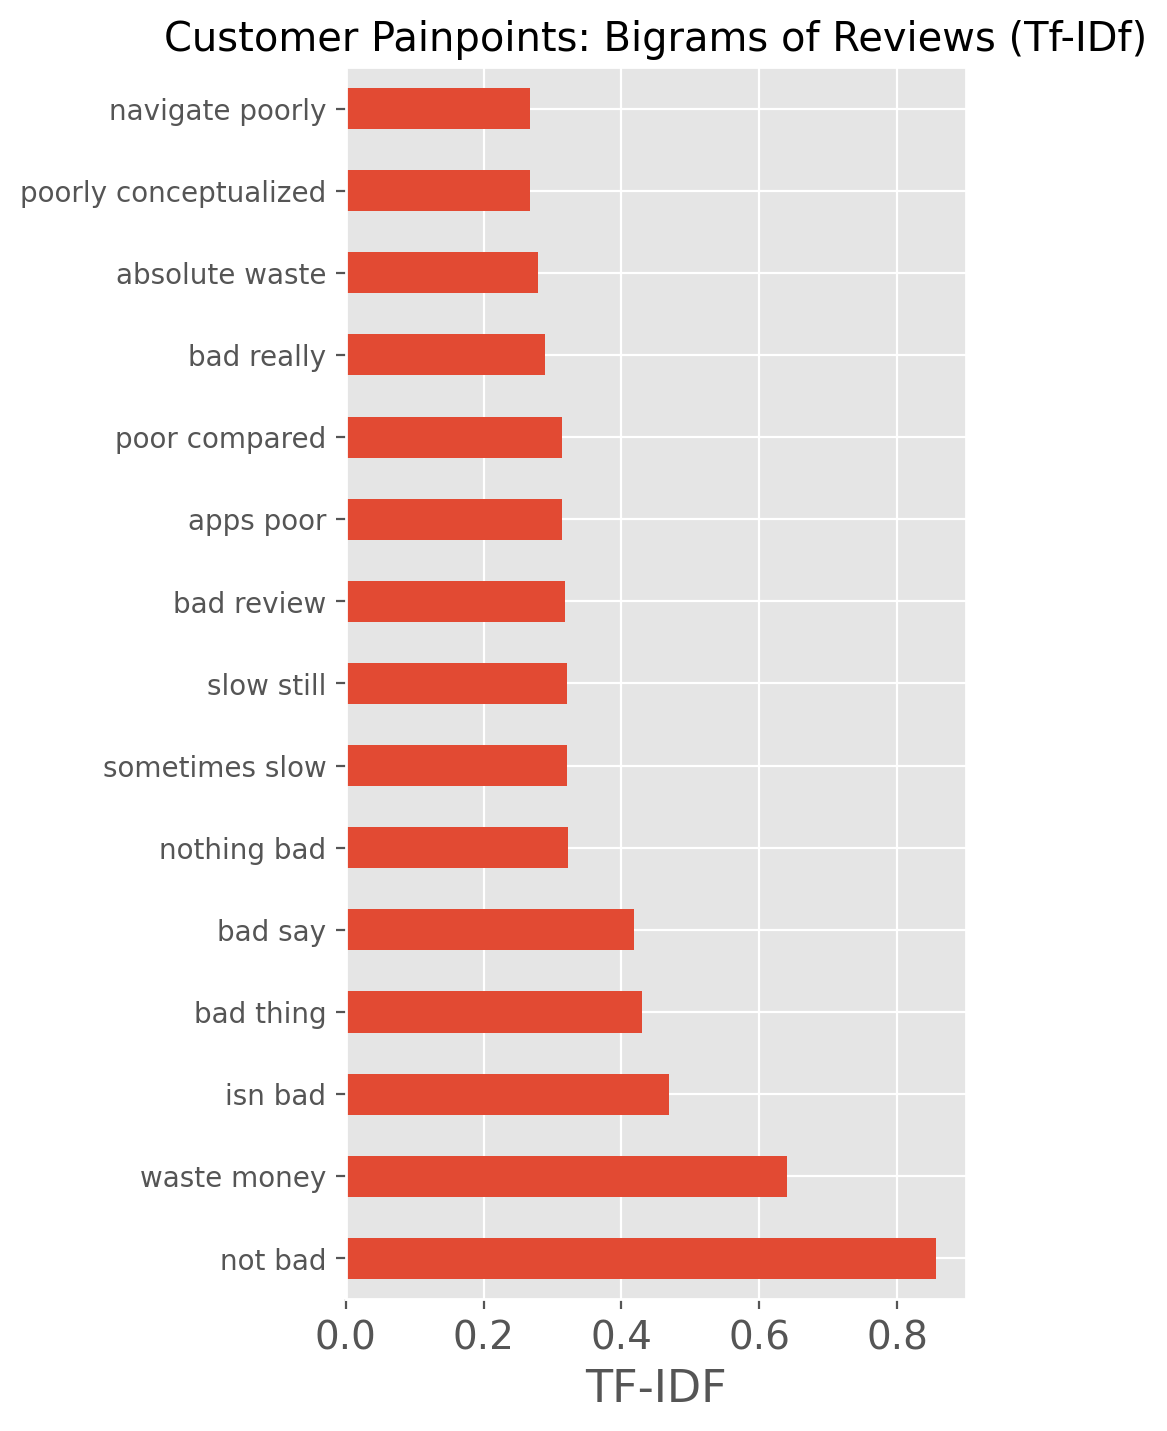

In [29]:
## Lets prepare a bar-chart on our top bad review bigrams based on Tf-IDf
plt.figure(figsize=(4, 8))
DTM_bigram_tfidf[tfidf_target_bad10_bigrams].sum().sort_values(ascending=False)[:15].plot.barh()
plt.xticks(fontsize=14) 
plt.xlabel('TF-IDF',fontsize = 16)
plt.title('Customer Painpoints: Bigrams of Reviews (Tf-IDf)')
plt.savefig('Customer Painpoints: Bigrams of Reviews (Tf-IDf).jpg')
plt.show();

Top 15 terms isn't very informative about customer pain points. Lets check again with top 30 bigrams.

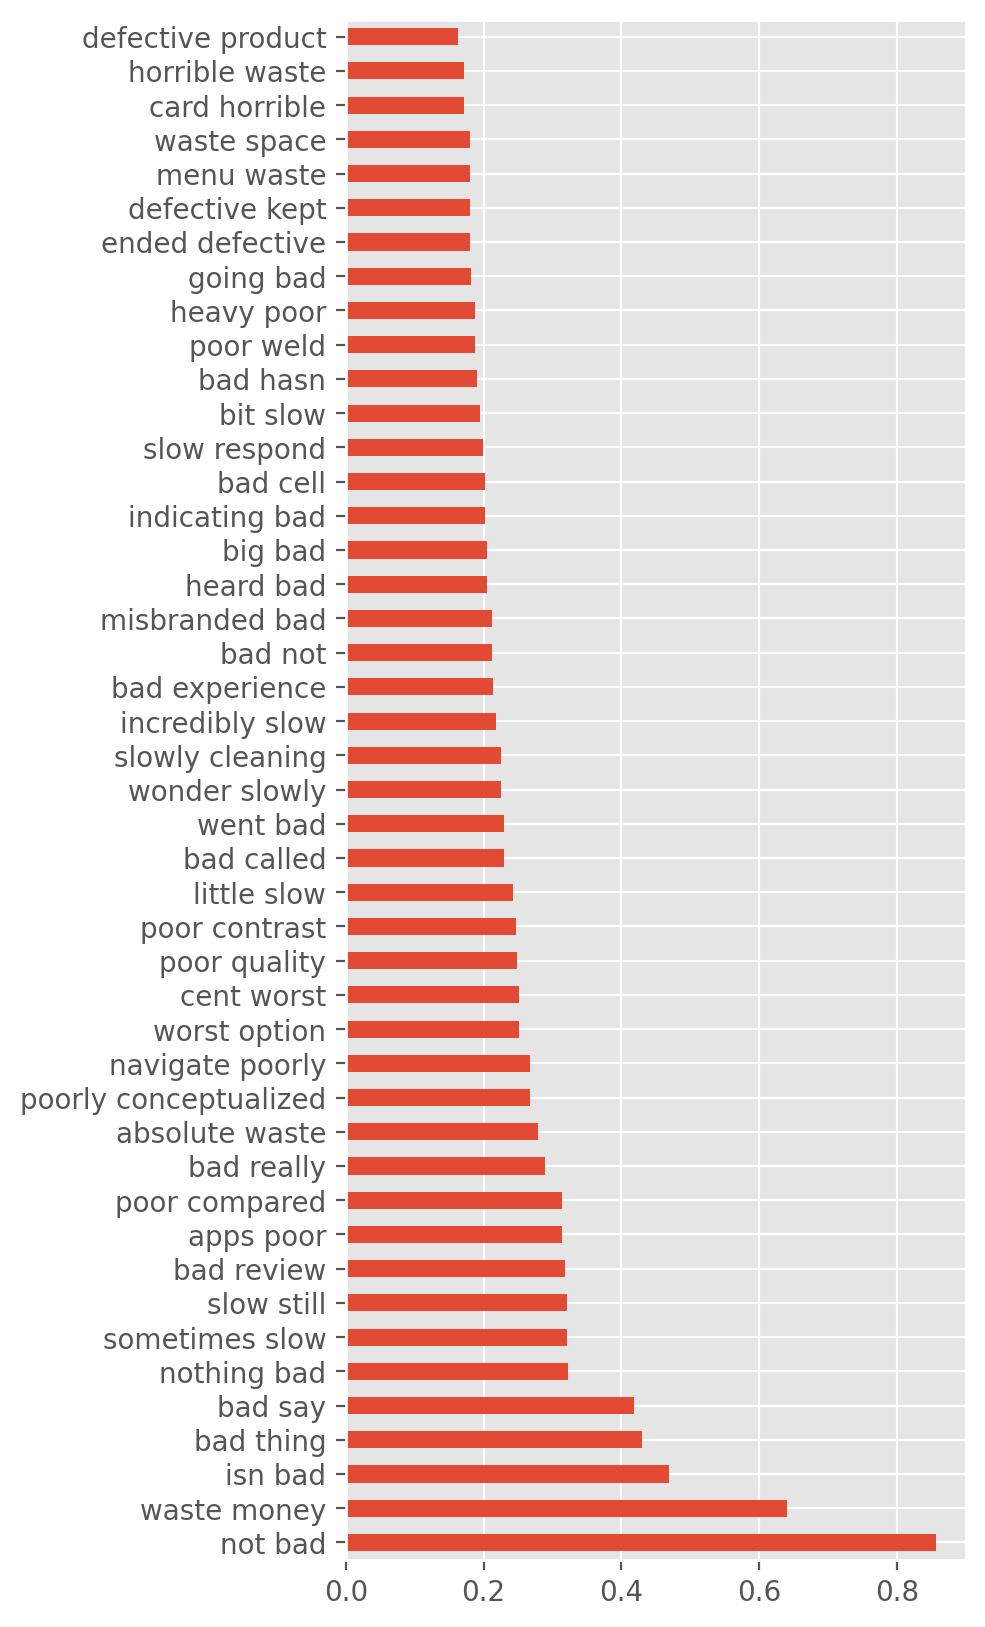

In [30]:
plt.figure(figsize=(4, 10))
DTM_bigram_tfidf[tfidf_target_bad10_bigrams].sum().sort_values(ascending=False)[:45].plot.barh();

### **Some top customer pain points based on the TF-IDF of Amazon review bigrams**
1. Value for money
2. Slow response
3. Poor app navigation
4. Poor conceptualization
5. Quality issues
6. Misbranded product
7. Poor contrast
8. Heavy
9. Defective items delivered

## **Customer pain points with Count Vectorized reviews**

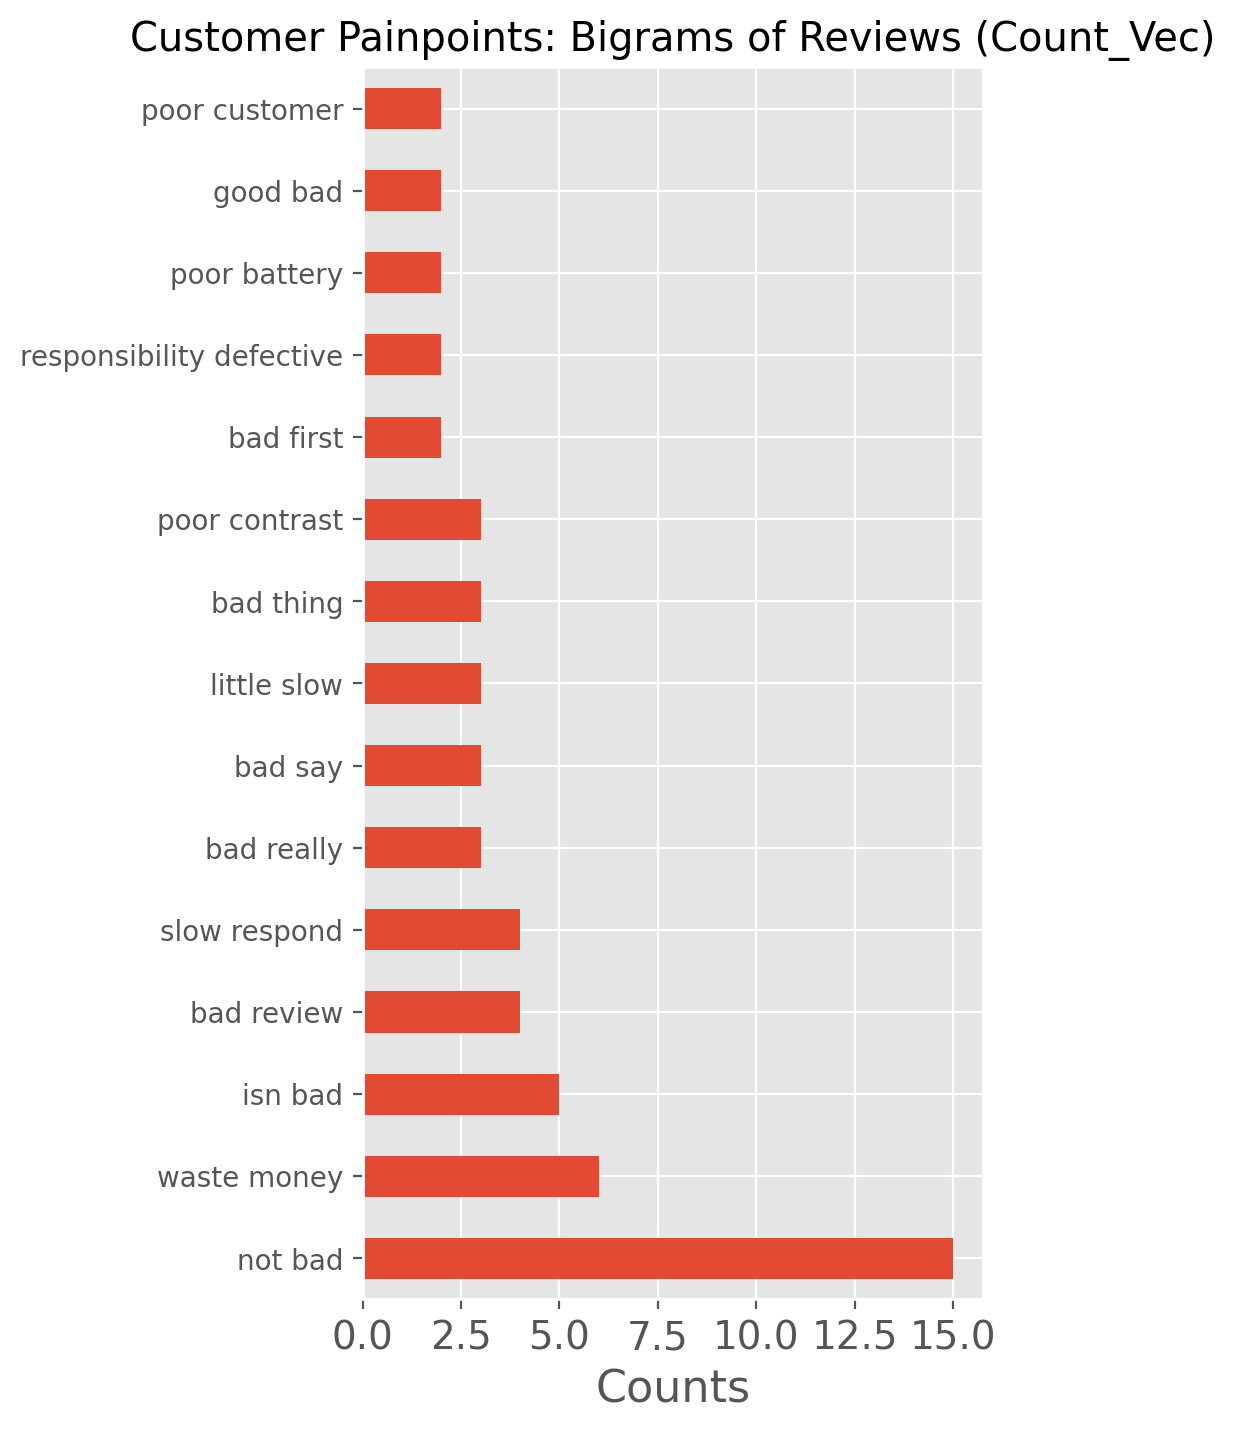

In [31]:
## Lets prepare a bar-chart on our top bad review bigrams based on Count Vectorizing
plt.figure(figsize=(4, 8))
DTM_bigram_count_vec[count_vec_bad10_bigrams].sum().sort_values(ascending=False)[:15].plot.barh()
plt.xticks(fontsize=14)
plt.xlabel('Counts',fontsize = 16)
plt.title('Customer Painpoints: Bigrams of Reviews (Count_Vec)')
plt.savefig('Customer Painpoints: Bigrams of Reviews (Count_Vec).jpg')
plt.show();

Top 15 terms isn't very informative about customer pain points. Lets check again with top 30 bigrams.

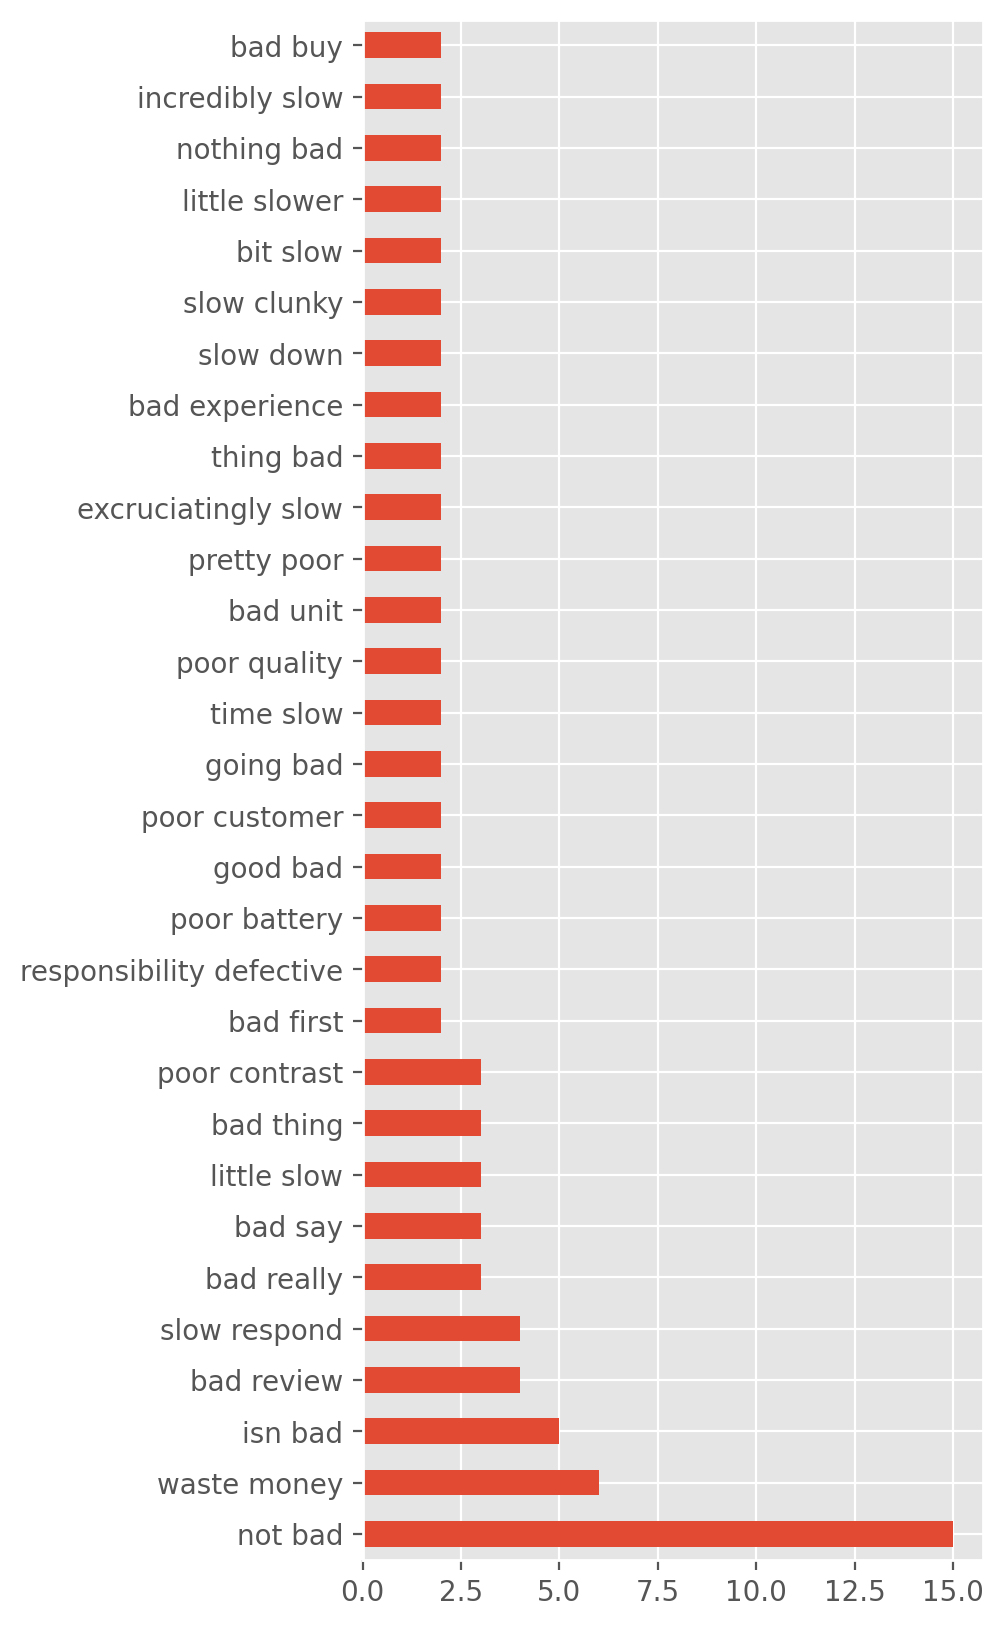

In [32]:
plt.figure(figsize=(4, 10))
DTM_bigram_count_vec[count_vec_bad10_bigrams].sum().sort_values(ascending=False)[:30].plot.barh();

### **Some top customer pain points based on Count Vectorizing Amazon review bigrams**
1. Not getting their value for money
2. Slow response
3. Poor contrast
4. Bad HD quality
5. Poor customer service
6. Not taking responsibility for defective items
7. Questionable item quality

<a id = '4'></a>
# [4. Word Cloud: visualizing top 15 customer bigrams from the list provided](#0)

**Lets Now build wordclouds on our top 15 problems**

In [33]:
tfidf_series = DTM_bigram_tfidf[tfidf_target_bad10_bigrams].sum()*100
tfidf_series = tfidf_series.map('{:.0f}'.format).astype(int)


In [34]:
('worked bad'+' ')*2

'worked bad worked bad '

In [35]:
tfidf_join = " "
for idx, (bigram, weight) in enumerate(zip(list(tfidf_series.index), list(tfidf_series.values))):
    tfidf_join = tfidf_join + (bigram + ' ')*weight

In [36]:
tfidf_join[:1400]

' absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste absolute waste access bad4 access bad4 access bad4 access bad4 access bad4 advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly advised poorly allow poor allow poor allow poor allow poor allow poor android bad android bad android bad android bad android bad android bad android bad android bad apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps poor apps po

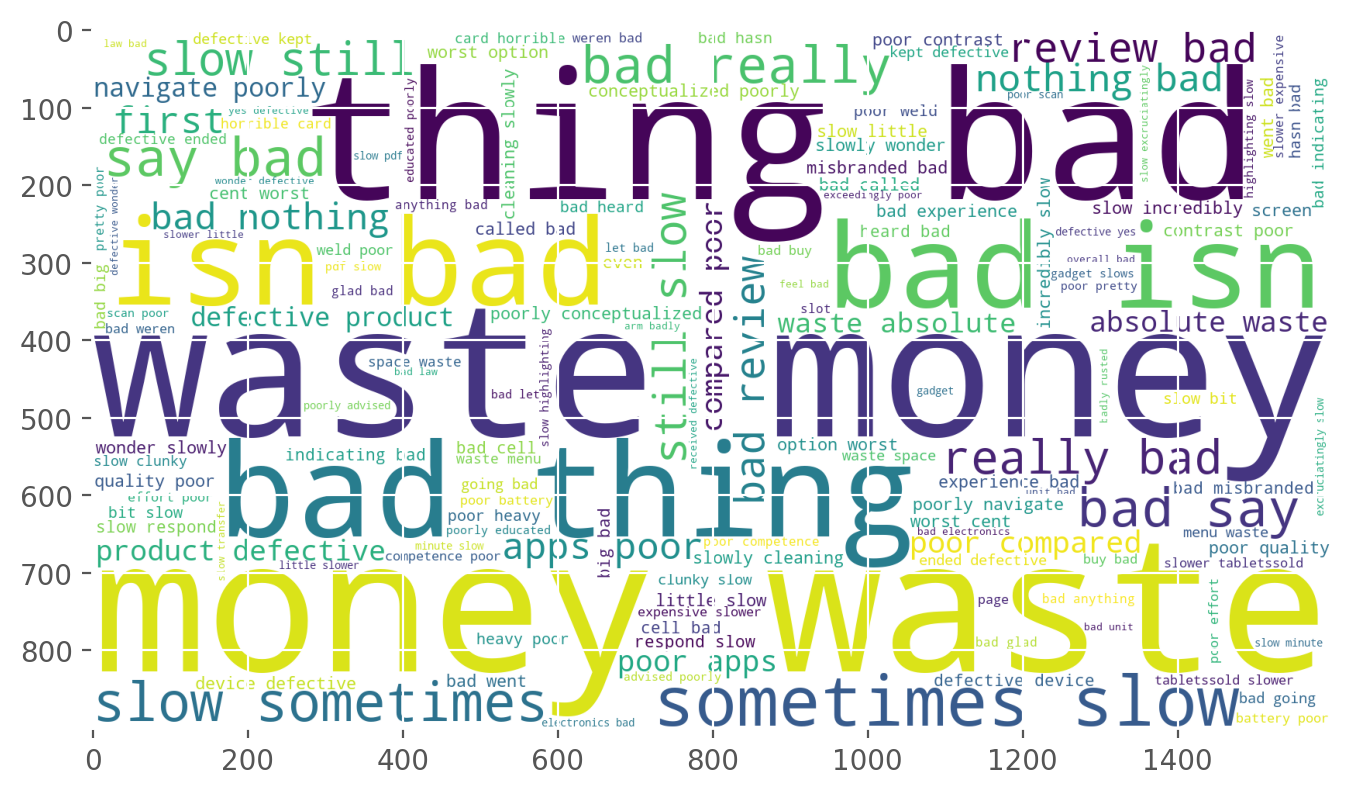

In [37]:
## Lets build a wordcloud now to identify

word_cloud = WordCloud(width=1600,height=900,
                       background_color='white',
                       max_words=150).generate(tfidf_join)
%config InlineBackend.figure_format="retina"
plt.figure(figsize=[8,8])
plt.imshow(word_cloud)
plt.savefig('Wordcloud with top customer issues (tfidf).png')
plt.show()

**Let's build another Wordcloud from Count Vecorized bigrams**

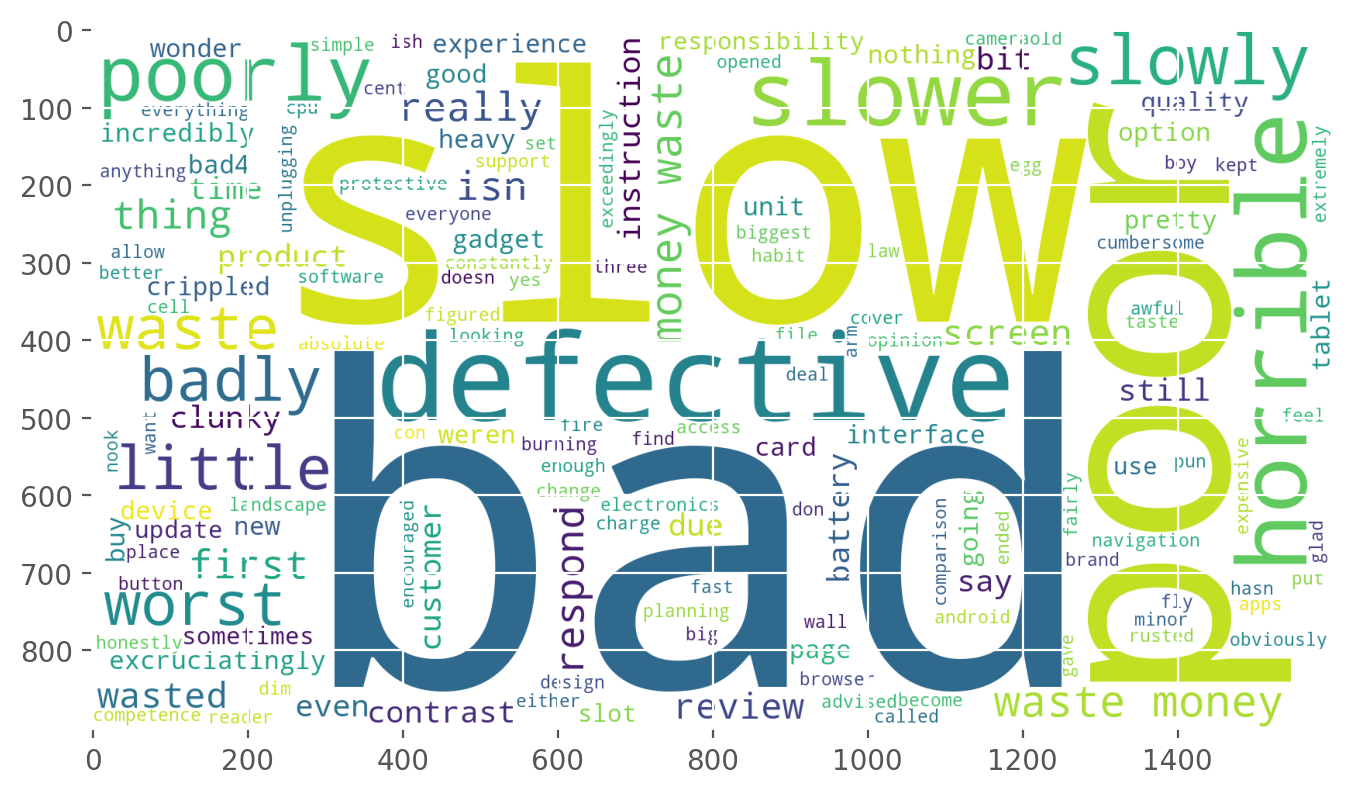

In [38]:
count_vec_series = DTM_bigram_count_vec[count_vec_bad10_bigrams].sum()
count_vec_series = count_vec_series.map('{:.0f}'.format).astype(int)

count_vec_series_join = " "
for idx, (bigram, weight) in enumerate(zip(list(count_vec_series.index), list(count_vec_series.values))):
    count_vec_series_join = count_vec_series_join + (bigram + ' ')*weight

## Lets build a wordcloud now to identify

word_cloud = WordCloud(width=1600,height=900,
                       background_color='white',
                       max_words=150).generate(count_vec_series_join)
%config InlineBackend.figure_format="retina"
plt.figure(figsize=[8,8])
plt.imshow(word_cloud)
plt.savefig('Wordcloud with top customer issues (count_vect).png')
plt.show()   

<a id = '5'></a>
# [5. Analysis and Recommendations](#0)
I have compared customer pain points using both CountVectorizing and by calculating the TF-IDF of the bigrams of reviews. Obviously, a deeper investigation is needed to analyze these issues accurately. 

**Based on preliminary analysis, I have identified the top 5 key areas of concern and provided my recommendations for handling these issues.**

**The top customer pain points about the product Barnes & Noble Nook are:**
- **1. Overpriced:** Not getting value for their money. Probably needs a look at their **pricing strategy and the customer segments** these reviews are coming from.
- **2. Device responsiveness:** Some users report a slowdown after purchase, and also poor customer service. Company needs to **revamp their customer servicing or risk customer churn** to competitor brands like Amazon Kindle.
- **3. App Navigation and display issues:** This feedback should be redirected to their **R&D deparment.**
- **4. Design issues:** Poor conceptualization, heavy, quality issues, misbranding. This is a specific **challenge to the Marketing and R&D team.** Material quality and design shouldn't be compromised since customers are reporting it as overpriced.
- **5. Delivering defective items:** This concerns the Supply Chain Management department. Regular QA/QC checks at the warehouses to be implemented. **Need to upgrade standards for 3rd party warehousing.** Need to ensure trusted vendors are partnered up till the last mile.